In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pycbc.waveform import td_approximants, get_td_waveform
from scipy.interpolate import interp1d
from simple_pe.waveforms import generate_eccentric_waveform, gen_component_wfs

/home/ben.patterson/.conda/envs/igwn_eccentric_new/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
/home/ben.patterson/.conda/envs/igwn_eccentric_new/lib/python3.10/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this p

lal.MSUN_SI != Msun


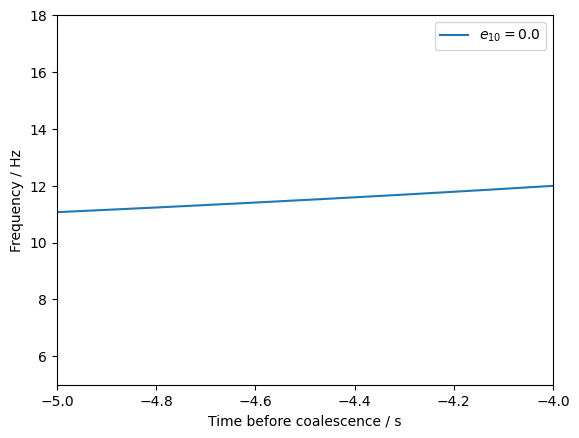

In [16]:
hp, hc = get_td_waveform(approximant='TEOBResumS',
                         mass1=40,
                         mass2=20,
                         spin1z=0,
                         delta_t=1.0/4096,
                         f_lower=10)
h = hp - 1j*hc
phase_diffs = np.diff(np.angle(h))
phase_diffs[phase_diffs>np.pi] -= 2*np.pi
freqs = np.abs(phase_diffs)*4096/(2*np.pi)
plt.plot(hp.sample_times[:-1], freqs, c='C0', label='$e_{10} = 0.0$')
plt.xlim(-5, -4)
plt.ylim(5, 18)
plt.xlabel('Time before coalescence / s')
plt.ylabel('Frequency / Hz')
plt.legend()
plt.savefig('Figures/circ_freq_mod.png', dpi=450)

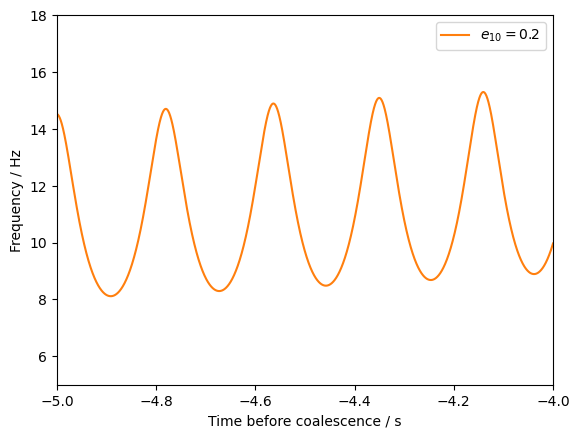

In [17]:
hp, hc = generate_eccentric_waveform(
    60, 2, 0.2, 0, 0, 10, 4096, phase=0, inclination=0,
    distance=1, f_ref_e=None, tlen=None, taper=False, to_fs=False,
    mode_array=[[2, 2]], align_merger=False, use_22_merger_time=True,
)
h = hp - 1j*hc
phase_diffs = np.diff(np.angle(h))
phase_diffs[phase_diffs>np.pi] -= 2*np.pi
freqs = np.abs(phase_diffs)*4096/(2*np.pi)
plt.plot(hp.sample_times[:-1], freqs, c='C1', label='$e_{10} = 0.2$')
plt.xlim(-5, -4)
plt.ylim(5, 18)
plt.xlabel('Time before coalescence / s')
plt.ylabel('Frequency / Hz')
plt.legend()
plt.savefig('Figures/ecc_freq_mod.png', dpi=450)

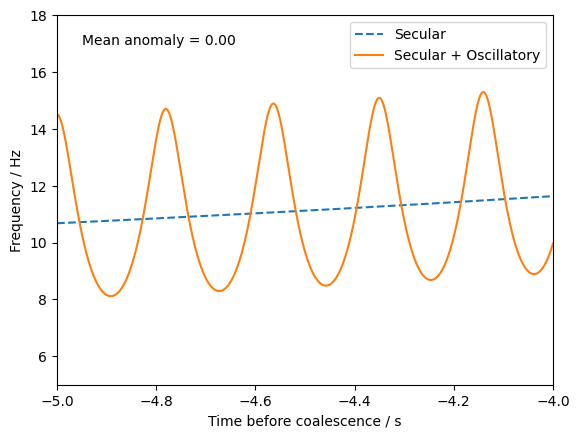

In [18]:
hp, hc = generate_eccentric_waveform(
    60, 2, 0.2, 0, 0, 10, 4096, phase=0, inclination=0,
    distance=1, f_ref_e=None, tlen=None, taper=False, to_fs=False,
    mode_array=[[2, 2]], align_merger=False, use_22_merger_time=True,
)
h = hp - 1j*hc
phase_diffs = np.diff(np.angle(h))
phase_diffs[phase_diffs>np.pi] -= 2*np.pi
freqs = np.abs(phase_diffs)*4096/(2*np.pi)

peri_inds = np.diff(np.sign(np.diff(np.abs(h)))) < 0
peri_times = h.sample_times[1:-1][peri_inds]
peri_freqs = freqs[1:][peri_inds]
apo_inds = np.diff(np.sign(np.diff(np.abs(h)))) > 0
apo_times = h.sample_times[1:-1][apo_inds]
apo_freqs = freqs[1:][apo_inds]

peri_interp = interp1d(peri_times, peri_freqs)
apo_interp = interp1d(apo_times, apo_freqs)
ts = np.linspace(-5, -4, 4097)
peri_fine = peri_interp(ts)
apo_fine = apo_interp(ts)
ecc_fine = (np.sqrt(peri_fine/apo_fine)-1)/(np.sqrt(peri_fine/apo_fine)+1)
f_sec_fine = ((1-ecc_fine)**2*peri_fine)/np.sqrt(1-ecc_fine**2)
f_sec_fine2 = ((1+ecc_fine)**2*apo_fine)/np.sqrt(1-ecc_fine**2)

plt.plot(ts, f_sec_fine, c='C0', ls='dashed', label='Secular')
plt.plot(hp.sample_times[:-1], freqs, c='C1', label='Secular + Oscillatory')
plt.text(0.05, 0.95, f'Mean anomaly = {0:.2f}', horizontalalignment='left',
         verticalalignment='top', transform=plt.gca().transAxes)
plt.xlim(-5, -4)
plt.ylim(5, 18)
plt.xlabel('Time before coalescence / s')
plt.ylabel('Frequency / Hz')
plt.legend()
plt.savefig('Figures/sec_freq_mod.png', dpi=450)

In [11]:
# Generate frames
frames = 60
wfs = gen_component_wfs(60, 2, 0.2, 0, 0, 10, 4096, 0, 0, 1, None, frames)
time_list = []
freq_list = []
for wf in wfs[::-1]:
    phase_diffs = np.diff(np.angle(wf))
    phase_diffs[phase_diffs>np.pi] -= 2*np.pi
    freqs = np.abs(phase_diffs)*4096/(2*np.pi)
    time_list.append(wf.sample_times[1:])
    freq_list.append(freqs)

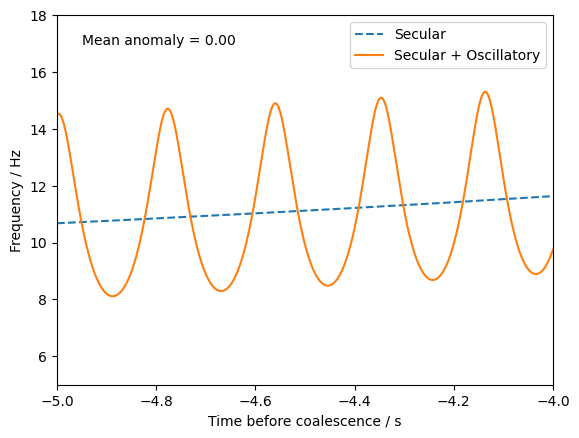

In [20]:
# Make animation
fig, ax = plt.subplots()
ax.plot(ts, f_sec_fine, c='C0', ls='dashed', label='Secular')
sec_osc = ax.plot(time_list[0], freq_list[0], c='C1', label='Secular + Oscillatory')[0]
ma_text = ax.text(0.05, 0.95, f'Mean anomaly = {0:.2f}', horizontalalignment='left',
                  verticalalignment='top', transform=ax.transAxes)
ax.legend()

def update(frame):
    ma = 2*np.pi*frame/frames
    ma_text.set_text(f'Mean anomaly = {ma:.2f}')
    sec_osc.set_xdata(time_list[frame])
    sec_osc.set_ydata(freq_list[frame])
    return (ma_text, sec_osc)

ani = animation.FuncAnimation(fig=fig, func=update, frames=frames, interval=1000/30)
ax.set_xlim(-5, -4)
ax.set_ylim(5, 18)
ax.set_xlabel('Time before coalescence / s')
ax.set_ylabel('Frequency / Hz')

ani.save(filename="Figures/vary_ma_freq_mods.gif", writer="pillow")

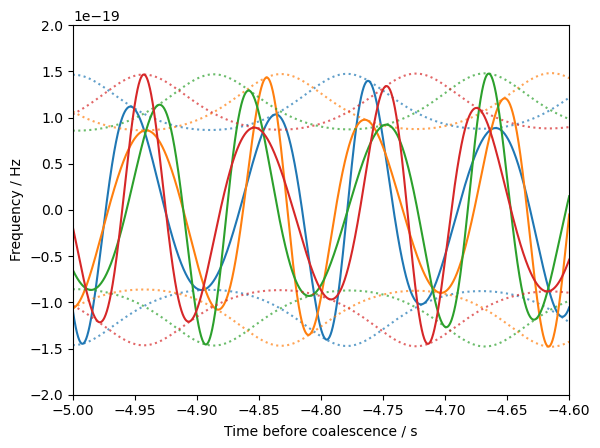

In [27]:
wfs = gen_component_wfs(60, 2, 0.2, 0, 0, 10, 4096, 0, 0, 1, None, 4)
for i, wf in enumerate(wfs):
    plt.plot(wf.sample_times, wf, c=f'C{i}')
    plt.plot(wf.sample_times, np.abs(wf), ls='dotted', alpha=0.7, c=f'C{i}')
    plt.plot(wf.sample_times, -np.abs(wf), ls='dotted', alpha=0.7, c=f'C{i}')
plt.xlim(-5, -4.6)
plt.ylim(-2e-19, 2e-19)
plt.xlabel('Time before coalescence / s')
plt.ylabel('Frequency / Hz')
plt.savefig('Figures/comp_wfs.png', dpi=450)